# **<center>An Inquiry Into Onsite Education as a Potential Driver of COVID-19 Transmission</center>**

<center>Amanjit Gill</center>







## **1. Introduction**

In September of 2021, schools in the Australian states that were experiencing significant COVID-19 outbreaks resumed onsite learning. There was a considerable amount of debate in the media (Sakkal & Fowler, 2021) about how this might impact transmission rates of COVID-19, and how best to balance the risks of infection with the purported risks to child development, mental health and academic progress from prelonged school closures (Davey, 2021).

Term 1 of 2022 was the first school term, since the start of the pandemic, to have been completed entirely onsite at Victorian schools. Publicly available data from the Victorian Department of Health (Vic. DH) make it possible to understand if transmission rates of COVID-19 might have been affected by the return to onsite learning, and if the risk mitigation measures employed by the Victorian Department of Education (DET) were beneficial in reducing transmission. This inquiry aims to advance that understanding, in posing the following questions:

**On transmission rates:**

1. What percentage of new COVID-19 cases at the start and end of Term 1 were children?

2. Which age group had the most new cases throughout the term?

3. How did the transmission rates in children compare to the general population, when the population size of each age group is accounted for?

4. Did the percentage of new infections that were children match the percentage of children in the general population?

**On risk mitigation measures:**

5. How did community case figures progress throughout the term, when compared to a jurisdiction with fewer measures in place?

6. How did the percentage share of paediatric cases in Victoria compare with a jurisdiction with fewer measures in place?

This topic of inquiry is of particular interest to the author due to the lack of consistency and clarity in public health messaging related to COVID-19. It is hoped that this analysis will go some way to clarifying the role that schools may play in virus transmission.  


## **2. Methodology**

Having established a focus for this inquiry, the following steps were undertaken to answer the six questions.

1. COVID-19 case data, broken into age groups, were obtained for Victoria.

2. COVID-19 case data were obtained for other states and territories, for the purpose of comparing Victoria's transmission management to that of another jurisdiction. Only one state was chosen, to limit the scope of the inquiry in recognition of time constraints.

3. Population data for each state and territory, broken into age groups, were obtained for the purpose of allowing fair comparisions between jurisdictions by normalising for population.

4. The selected datasets were examined to confirm suitability and then extensively cleaned.

5. The cleaned datasets were further manipulated, and visualisations created, to answer the six questions and ultimately address the central focus of the inquiry - the impact of onsite education on COVID-19 transmission rates.


## **3. Data Collection and Cleaning**

The Python libraries used in this analysis are listed below.


In [1]:
import pandas as pd
import numpy as np
import xlrd
from matplotlib import rcParams
from datetime import datetime

# Maintain consistent styling for figures
FIGSIZE=[12, 7]
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 13

### **3.1 Victorian COVID-19 Case Data**

The Victorian government's open data platform offers a line list (one case per line) of all COVID-19 cases to date, in CSV format (Vic. DH, 2020). It includes the diagnosis date and age group. However, this dataset does not include positive results from RATs (rapid antigen tests); this is a significant omission because the use of RATs is promoted by Vic. DH. Most new cases are self-reported positive RATs (Vic. DH, n.d.), not from PCR (polymerase chain reaction) tests processed by pathology laboratories.

Fortunately, an alternative data source is available on the government's COVID-19 dashboard page (Vic. DH, n.d.). The bar graph showing the number of new cases by age group uses a publicly available Tableau workbook (Vic. DH, n.d.). From here, there are **ten** tables - one per age group - available for download in CSV format. These tables include positive cases from both RATs and PCR, making them suitable for analysis.

Each of the ten CSV files presents 'male' and 'female' cases separately. This means that the dates are all duplicated - each date appears on two rows, one for 'male' cases and one for 'female' cases. In addition, there are hundreds of rows representing periods when there were very few - or zero - known cases in the community, rendering those rows of little value to the present inquiry. A sample of these unneeded rows now follows.

In [2]:
df = pd.read_csv(f'sources/0-9.csv')
df.head()

,agegroup,Cases_Male,Active_Cases,Cases,Daily_Recovered,Date,Sex,Cases_Female
0,0-9,0.0,0.0,0.0,0.0,1/25/2020,Female,0.0
1,0-9,0.0,0.0,0.0,0.0,1/25/2020,Male,0.0
2,0-9,0.0,0.0,0.0,0.0,1/26/2020,Female,0.0
3,0-9,0.0,0.0,0.0,0.0,1/26/2020,Male,0.0
4,0-9,0.0,0.0,0.0,0.0,1/27/2020,Female,0.0


The table is disorganised. It is apparent that it was built and quickly adapted in response to rapidly changing government priorities throughout the first two years of the pandemic. An explanation of the more confusing columns is below.

- Cases_Male and Cases_Female: The number of newly reported cases. Only one of these columns applies to each row. If the Cases_Female cell contains a non-zero number, then the Cases_Male cell will be zero (0).
- Cases: This is a duplicate of either Cases_Male or Cases_Female, depending on which of these applies to the row.
- Sex: This indicates whether the figures in the row apply to male or female cases.
- Daily Recovered: The number of people removed from the state's 'active cases' on a given day.
- Active cases: The number of active cases in Victoria, after accounting for Daily_Recovered and Cases.

All ten CSV files required extensive cleaning. The 'male' and 'female' case numbers needed to be consolidated into a single figure per day. Then, because each file represented only one age group, the cleaned temporal data from the ten files were combined into a single, easy to read, data frame. 

The following function was defined for the purpose of cleaning one Victorian file. It performs these tasks:

- reorder and rename columns
- convert date strings into datetime objects
- group duplicate dates (thus consolidating 'male' and 'female' case numbers)
- retain rows from 1 Jan 2022 onwards, to cover the period leading up to Term 1 as well as Term 1 itself.


In [3]:
def clean_vic_df(age_file):
        
    # read in provided filename
    df = pd.read_csv(f'sources/{age_file}.csv')
    
    # drop unneeded columns
    df.drop(['Active_Cases', 'Daily_Recovered', 'Cases', 'Sex'], axis=1, inplace=True)

    # reorder columns
    df = df[['Date', 'agegroup', 'Cases_Male', 'Cases_Female']]

    # convert date strings to python datetime objects
    df['Date'] = pd.to_datetime(df['Date'])
    
    # combine duplicate dates; add male and female cases
    df = df.groupby('Date').sum()
    df['Cases'] = df['Cases_Male'] + df['Cases_Female']
    
    # retain only dates from 1/1/22 to 8/4/22
    start_vic = datetime(2022, 1, 1)
    end_vic = datetime(2022, 4, 8)
    df = df[start_vic:end_vic]

    # drop male and female cases; no longer needed
    df.drop(['Cases_Male', 'Cases_Female'], axis=1, inplace=True)
    
    # convert entire df to int to remove rounding
    df = df.astype("int")

    # rename column to age range
    df.columns = [age_file]
        
    return df

The function was executed ten times, once for each age group. Note that the 80-89 and 90+ age groups were combined into one, in order to better match available population data.

In [4]:
# list of filenames
age_files = [
    '0-9', '10-19', '20-29', '30-39', '40-49',
    '50-59', '60-69', '70-79', '80-89', '90+'
    ]

df_vic = pd.DataFrame()

# process each age group then append it to df_vic
for file in age_files:
    df_vic = pd.concat([df_vic, clean_vic_df(file)], axis=1)

# combine 80-89 and 90+ to better match ABS age groups
df_vic['80+'] = df_vic['80-89'] + df_vic['90+']
df_vic.drop(['80-89', '90+'], axis=1, inplace=True)
        
df_vic.head()

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
Date,,,,,,,,,
2022-01-01,389,705,2784,1406,605,608,342,180,71
2022-01-02,459,828,3294,1682,800,743,395,174,107
2022-01-03,654,1470,5372,2626,1263,1274,640,261,166
2022-01-04,805,1992,7046,3025,1628,1421,793,301,131
2022-01-05,776,2676,9464,3827,1863,1715,878,342,122


### **3.2 Queensland COVID-19 Data**

While the Victorian government adopted transmission reduction measures such as sentinel testing and HEPA (high efficiency particulate air) filtration, the Queensland government decided against widespread use of these strategies (Garcia, 2022). This makes Queensland a suitable jurisdiction against which Victoria's COVID-19 transmission patterns can be compared, in order to assess the effectiveness of Victoria's measures.

Fortunately, the Queensland open data portal offers a line list (one case per line) that is excellent quality and downloadable as a CSV file (Queensland Health, n.d.). Each line includes a diagnosis date and age group, as shown below.


In [5]:
df_qld = pd.read_csv('sources/qld_all_ages.csv')
df_qld.head()

,NOTIFICATION_DATE,AGE_GROUP_5Y
0,28/01/2020,40-44 years
1,30/01/2020,40-44 years
2,04/02/2020,05-09 years
3,04/02/2020,35-39 years
4,06/02/2020,35-39 years


Unlike the Victorian data, the cleaning process for these Queensland data was a simple exercise involving only a single file. The following tasks were undertaken:

- convert date strings into datetime objects
- aggregate all the cases that share the same date, and break into columns by age group
- consolidate age groups into larger bins for easier comparison with Victoria
- rename or remove columns
- replace null values with zero (0)
- retain rows from 1 Jan 2022 onwards, to cover the period leading up to Term 1 as well as Term 1 itself, noting that the term dates for Queensland are different to those for Victoria.


In [6]:
# rename columns
df_qld.columns = ['date', 'age_group']

# convert date strings into datetime objects
df_qld['date'] = pd.to_datetime(df_qld['date'], infer_datetime_format=True)

# collect age groups belonging to each date
# add up age group totals for every day
# unstack - make age groups their own columns
df_qld = df_qld.groupby(['date']).value_counts().unstack()

# retain only dates from 1/1/22 to 1/4/22
start_qld = datetime(2022, 1, 1)
end_qld = datetime(2022, 4, 1)
df_qld = df_qld[start_qld:end_qld]

# create list of original age groups to drop later
orig_age_groups = df_qld.columns.to_list()

# replace NaN with 0
df_qld = df_qld.replace(np.nan, 0)

# combine age groups to match vic and abs
df_qld['0-9'] = df_qld['00-04 years'] + df_qld['05-09 years']
df_qld['10-19'] = df_qld['10-14 years'] + df_qld['15-19 years']
df_qld['20-29'] = df_qld['20-24 years'] + df_qld['25-29 years']
df_qld['30-39'] = df_qld['30-34 years'] + df_qld['35-39 years']
df_qld['40-49'] = df_qld['40-44 years'] + df_qld['45-49 years']
df_qld['50-59'] = df_qld['50-54 years'] + df_qld['55-59 years']
df_qld['60-69'] = df_qld['60-64 years'] + df_qld['65-69 years']
df_qld['70-79'] = df_qld['70-74 years'] + df_qld['75-79 years']
df_qld['80+'] = df_qld['80-84 years'] + df_qld['85-89 years'] \
    + df_qld['90-94 years'] + df_qld['95-99 years'] + df_qld['100+ years']

# drop original columns
df_qld.drop(orig_age_groups, axis=1, inplace=True)

# convert all to int
df_qld = df_qld.astype("int")

df_qld.head()

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
date,,,,,,,,,
2022-01-01,206,490,1621,874,555,428,225,104,59
2022-01-02,241,744,2254,945,570,463,246,115,46
2022-01-03,331,1253,3882,1552,912,675,332,129,59
2022-01-04,379,1602,4982,2077,1112,848,373,130,71
2022-01-05,380,1686,5382,2208,1298,928,401,159,63


### **3.3 Age-Grouped Population Data**

The ABS (Australian Bureau of Statistics) offers very detailed population data, broken into small geographical areas and age groups. This is downloadable as a multiple-sheet Excel file (ABS, 2021). Because it is formatted for readability by humans, it is not designed to be machine-readable, so preparation of these data for analysis was unexpectedly laborious.


In [7]:
df_pop = pd.read_excel('sources/abs.xls', sheet_name='Table 3')
df_pop.head(2)

,Australian Bureau of Statistics,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,"Regional population by age and sex, 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Released at 11.30am (Canberra time) 27 August ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When read into a dataframe, the data appeared disorganised and mislabeled. By comparing with the original Excel file, it was observed that:

- There is one row per region.
- The columns from 'Unnamed: 10' to 'Unnamed: 27' contain the population for each region by age group.
- After all the rows for each state/territory, there is a row containing the total population for all regions in that jurisdiction, by age group.

This understanding of where the required population data were situated within the Excel sheet allowed the following cleaning and preparation tasks to occur:

- rename columns and rows
- combine the age groups into larger bins to match Victorian data
- discard all rows except for those containing state totals
- discard all columns except for those containing age-grouped data

In [8]:
df_pop = pd.read_excel('sources/abs.xls', sheet_name='Table 3')

# rename columns to more easily work with age groups
# first edit the column labels from QLD as it's similar to the ABS groupings
del orig_age_groups[18:21]
del orig_age_groups[3]
orig_age_groups.append('85+ years')

# rename age-group columns in dataset
col_dict = {}
for i in range(10, 28):
    col_dict["Unnamed: " + str(i)] = orig_age_groups[i-10]  
    
df_pop.rename(columns=col_dict, inplace=True)

# combine age groups to match vic and qld
df_pop['0-9'] = df_pop['00-04 years'] + df_pop['05-09 years']
df_pop['10-19'] = df_pop['10-14 years'] + df_pop['15-19 years']
df_pop['20-29'] = df_pop['20-24 years'] + df_pop['25-29 years']
df_pop['30-39'] = df_pop['30-34 years'] + df_pop['35-39 years']
df_pop['40-49'] = df_pop['40-44 years'] + df_pop['45-49 years']
df_pop['50-59'] = df_pop['50-54 years'] + df_pop['55-59 years']
df_pop['60-69'] = df_pop['60-64 years'] + df_pop['65-69 years']
df_pop['70-79'] = df_pop['70-74 years'] + df_pop['75-79 years']
df_pop['80+'] = df_pop['80-84 years'] + df_pop['85+ years']

# rename column that contains headings for state totals
df_pop.rename(columns = {'Unnamed: 1': 'state'}, inplace=True)

# drop original age groups and remaining "Unnamed" columns
keep_cols = [col for col in df_pop.columns \
    if not(col.startswith('Unnamed') | col.endswith('years'))]
df_pop = df_pop[keep_cols]

# retain only the rows that contain state totals
def contains_total(x):
    if str(x).startswith('TOTAL'):
        return True
    else:
        return False
    
df_pop = df_pop[df_pop['state'].apply(contains_total)]

# remove one last column that hasn't been caught yet
df_pop.dropna(axis=1, inplace=True)

# set index to state abbreviations for easier selections
# then drop state column
df_pop.index = ['nsw', 'vic', 'qld', 'sa', 'wa', 'tas', 'nt', 'act']
df_pop.drop('state', axis=1, inplace=True)

df_pop

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
nsw,1007869,969431,1148124,1194414,1039901,979824,865363,608521,354085
vic,818646,774408,1006743,1029094,856568,792986,674706,467529,275990
qld,653849,664219,709292,716760,673211,638657,542431,382809,194958
sa,204463,207480,232170,234689,217189,226383,207487,151073,89441
wa,346736,325420,351572,402284,352179,330587,274502,181714,98567
tas,60984,64337,65756,65410,64257,72013,70868,50893,26262
nt,35566,32109,38125,44359,33704,29733,20204,9409,2934
act,56732,49882,66618,71088,59258,49276,38580,26368,13578


## **4. Results**


### **Question 1**

*What percentage of new COVID-19 cases at the start and end of Term 1 were children?*

In [9]:
# slice term 1
start_term = '2022-01-31'
end_term = '2022-04-08'
df_term = df_vic[start_term:end_term]

# compute percentage of child cases at start of term
all_start = df_term.loc[start_term].sum()
child_start = df_term.loc[start_term, '0-9'] + df_term.loc[start_term, '10-19']
percent_start = round(child_start/all_start * 100)
print('Start of term:\t{}/{} cases were children:\t{}%'.format(
    child_start, all_start, percent_start))

# compute percentage of child cases at end of term
all_end = df_term.loc[end_term].sum()
child_end = df_term.loc[end_term, '0-9'] + df_term.loc[end_term, '10-19']
percent_end = round(child_end/all_end * 100)
print('End of term:\t{}/{} cases were children:\t{}%'.format(
    child_end, all_end, percent_end))

Start of term:	3584/11106 cases were children:	32%
End of term:	2390/9348 cases were children:	26%


This shows that onsite attendance for the entirety of Term 1 did not result in children taking a greater share of COVID-19 diagnoses than they were at the start of the term. This is reassuring; however, as shown in the response to Question 4, children comprise approximately 12% of the Victorian population, so 26% is a disproportionate share of the cases.

### **Question 2**

*Which age group had the most new cases throughout the term?*


Age group with most cases throughout Term 1:	10-19
Number of cases in 10-19 age group:		113696


<AxesSubplot:title={'center':'COVID-19 Cases by Age Group'}, xlabel='Age Group', ylabel='Cases'>

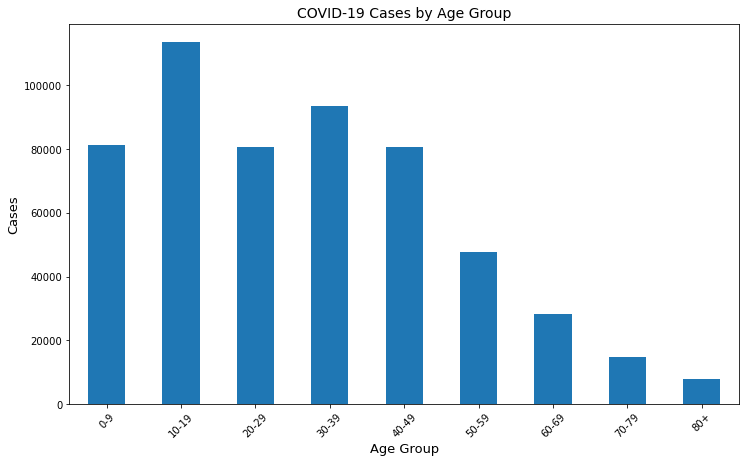

In [10]:
# find index and value for age group with the most cases
age_group_max = df_term.sum().idxmax()
max_cases = df_term.sum().max()

print(f'Age group with most cases throughout Term 1:\t{age_group_max}')
print(f'Number of cases in {age_group_max} age group:\t\t{max_cases}')

df_term.sum().plot(
    kind='bar',
    title='COVID-19 Cases by Age Group',
    xlabel='Age Group',
    ylabel='Cases',
    rot=45,
    figsize=FIGSIZE
    )

Children aged 10-19 had the highest number of COVID-19 diagnoses of any group during Term 1. The next highest caseload was for adults aged 30-39. This may be a byproduct of children bringing the virus home to their parents.

The 0-9 age group is not among the top two groups. One possible reason for this is that at the start of the term, approximately 40% of children aged 5-11 had received a dose of the COVID-19 vaccine within the previous few weeks (Australian Government Department of Health, 2022); by contrast, many teenagers aged 12-15 had not received a dose of the vaccine since the previous year, and were thus relatively unprotected when school resumed for Term 1.

### **Question 3**

*How did the transmission rates in children compare to the general population, when the population size of each age group is accounted for?*

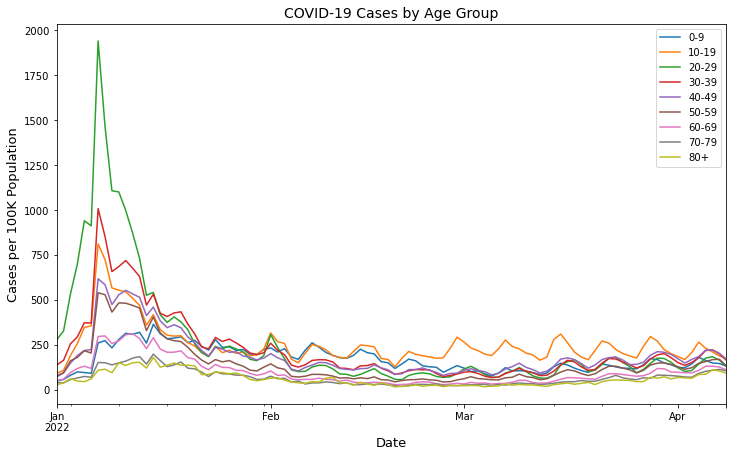

In [11]:
# population of each age group in Vic
s_vic_pops = df_pop.loc['vic']

# list of column names i.e. age groups
vic_ages = df_vic.columns.to_list()

df_vic_pop = pd.DataFrame()

# for each age group, normalise by its own population
for age, pop in zip(vic_ages, s_vic_pops):
    df_vic_pop[age] = df_vic[age] / pop * 100000
    df_vic_pop[age].plot(
        legend=True,
        title='COVID-19 Cases by Age Group',
        ylabel='Cases per 100K Population',
        figsize=FIGSIZE
        )

Term 1 started on 31 January 2022. Before this date, the highest caseload per 100,000 population was for young adults aged 20-29. Then a few weeks into the term, a clear trend emerged wherein children aged 10-19 consistently outnumbered all other age groups for the remainder of the term.

### **Question 4**

*Did the percentage of new infections that were children match the percentage of children in the general population?*

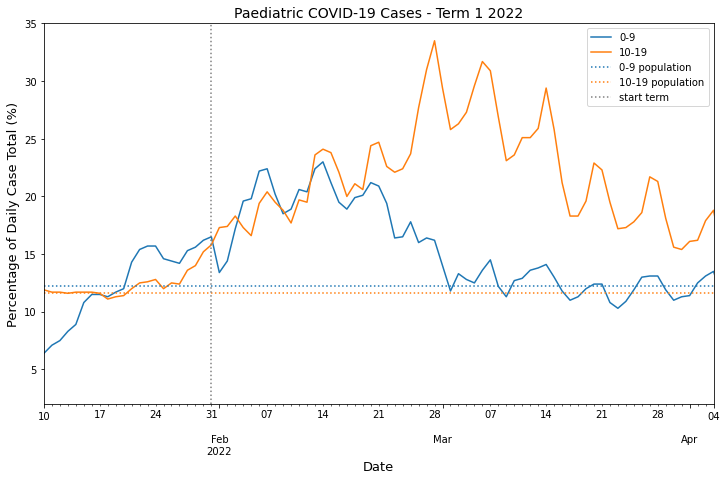

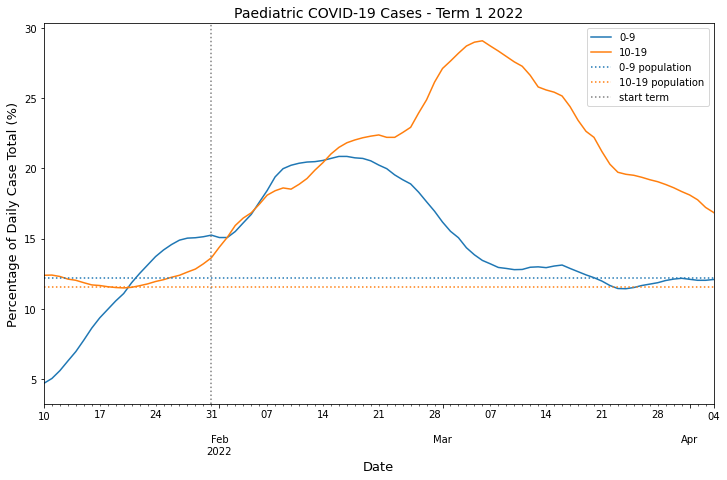

In [12]:
# percentage of whole population that is aged 0-9 and 10-19
vic_pop_total = s_vic_pops.sum()
vic_perc_0_9 = round(s_vic_pops['0-9'] / vic_pop_total * 100, 1)
vic_perc_10_19 = round(s_vic_pops['10-19'] / vic_pop_total * 100, 1)

# percentage of daily cases belonging to each age group
df_vic_perc = pd.DataFrame()
df_vic_perc[vic_ages] = df_vic[vic_ages].div(
    df_vic.sum(axis=1), axis=0).mul(100).round(1)

# plot both unsmoothed and smoothed
ax1 = df_vic_perc[['0-9', '10-19']].plot(
    figsize=FIGSIZE, xlim=('2022-01-10', '2022-04-04'))
ax2 = df_vic_perc[['0-9', '10-19']].rolling(7).mean().plot(
    figsize=FIGSIZE, xlim=('2022-01-10', '2022-04-04'))

# add population lines and term start line
# first get colours matching the plots
# then add the matching population line for each plot in its matching colour 
# then add term start/end lines
col1 = ax1.lines[0].get_color()
col2 = ax1.lines[1].get_color()

# plot horizontal and vertical lines on both original and smoothed graphs
for ax in [ax1, ax2]:
    ax.axhline(y=vic_perc_0_9, linestyle=':', color=col1, label='0-9 population')
    ax.axhline(y=vic_perc_10_19, linestyle=':', color=col2, label='10-19 population')
    ax.axvline(x=start_term, linestyle=':', color='grey', label='start term')
    ax.set_title('Paediatric COVID-19 Cases - Term 1 2022')
    ax.legend()
    ax.set_ylabel('Percentage of Daily Case Total (%)')

The first plot is showing high amplitude oscillation about its path, possibly due to weekly sentinel testing or the increased transmission potential occurring on weekends. Because of this, a second plot is shown, which is identical to the first except for the application of a rolling mean for smoothing.

Children comprise approximately 12% of the Victorian population. It is clear that children aged 10-19, in particular, were tremendously over-represented in COVID-19 diagnoses throughout Term 1.  

This was also the case for children aged 0-9 until early March, after which time their share of new cases stabilised around 12%, indicating a consistently proportionate share of Victorian COVID-19 cases.

### **Question 5**

*How did community case figures progress throughout the term, when compared to a jurisdiction with fewer measures in place?*

Text(0, 0.5, 'Cases Per 100K Population')

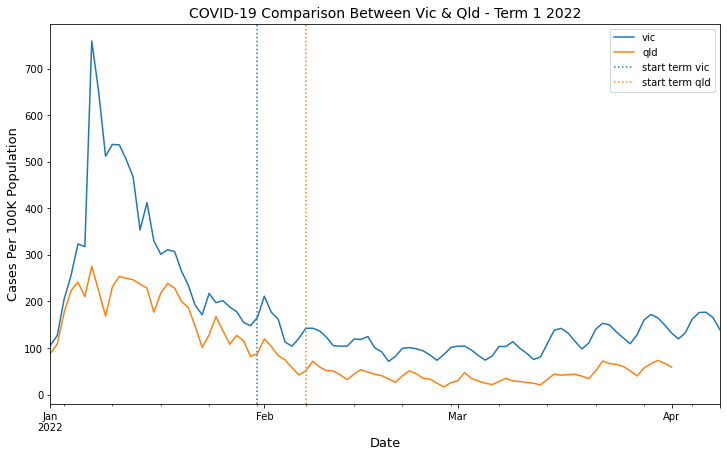

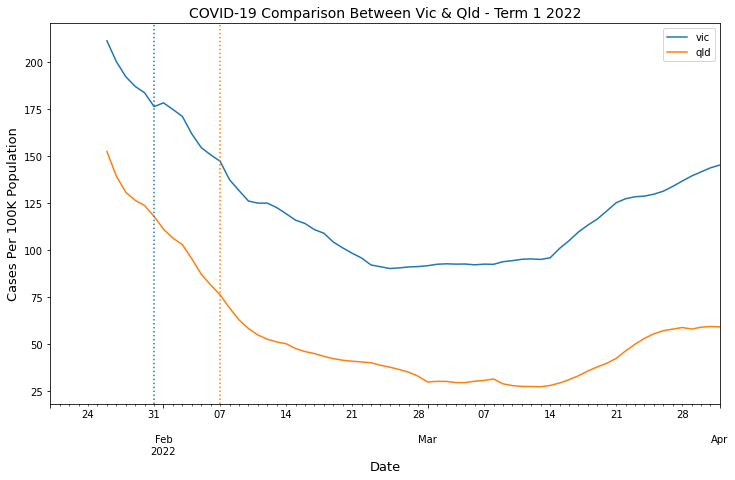

In [13]:
# get case total per day; normalise for 100,000 population
df_vq_total = pd.DataFrame()
df_vq_total['vic'] = df_vic.sum(axis=1) / df_pop.loc['vic'].sum() * 100000
df_vq_total['qld'] = df_qld.sum(axis=1) / df_pop.loc['qld'].sum() * 100000

# Qld term dates
start_term_qld = datetime(2022, 2, 7)
end_term_qld = datetime(2022, 4, 1)

# plot and add vertical date lines
ax1 = df_vq_total.plot(figsize=FIGSIZE)
ax1.axvline(x=start_term, linestyle=':', color=col1, label='start term vic')
ax1.axvline(x=start_term_qld, linestyle=':', color=col2, label='start term qld')
ax1.set_title('COVID-19 Comparison Between Vic & Qld - Term 1 2022')
ax1.set_ylabel('Cases Per 100K Population')
ax1.legend()

# redo plot for closer view
ax2 = df_vq_total.loc[datetime(2022, 1, 20):end_term_qld].rolling(7).mean().plot(
    figsize=FIGSIZE)
ax2.axvline(x=start_term, linestyle=':', color=col1, label='start term vic')
ax2.axvline(x=start_term_qld, linestyle=':', color=col2, label='start term qld')
ax2.set_title('COVID-19 Comparison Between Vic & Qld - Term 1 2022')
ax2.set_ylabel('Cases Per 100K Population')

The first Victorian plot is showing noticeable oscillation about its path. This may be a byproduct of sentinel testing performed at the start of every week of the term, or it may be due to new infections arising from social activities on the weekend.

The second plot is the same as the first, except it has been smoothed by applying a 7-day rolling mean. In addition, the period of observations has been shortened by removing most of January, allowing a closer view of the trend through Term 1. 

It is clear that both Victoria and Queensland were experiencing gentle growth in daily diagnoses when the term ended. However, due to the similar case trajectories of the two states, there is no indication here that Victoria has been advantaged by the additional measures it has taken to reduce COVID-19 transmission in schools.

### **Question 6**

*How did the percentage share of paediatric cases in Victoria compare with a jurisdiction with fewer measures in place?*

<AxesSubplot:title={'center':'Age Distribution of COVID Cases for Vic and Qld'}, xlabel='Age Group', ylabel='Percentage of Total Cases (%)'>

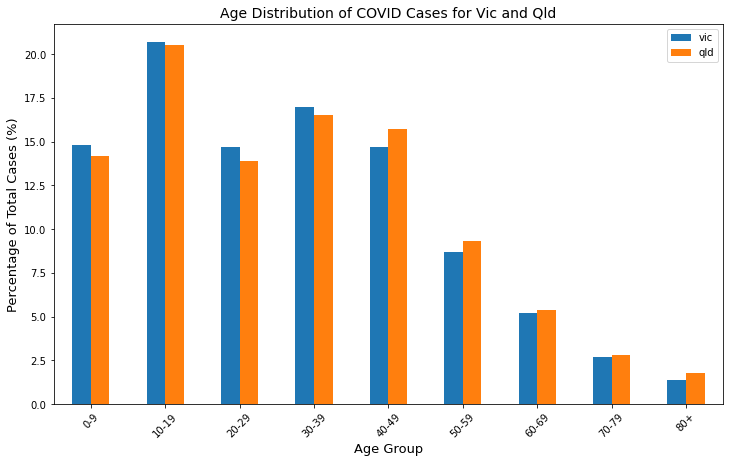

In [14]:
# percentage of total cases belonging to each age group
vic_total = df_term.sum().sum()
s_vic_perc = round(df_term.sum() / vic_total * 100, 1)

# slice just term dates for Qld
# then find percentage of total cases for each age group
df_term_qld = df_qld[start_term_qld:end_term_qld]
qld_total = df_term_qld.sum().sum()
s_qld_perc = round(df_term_qld.sum() / qld_total * 100, 1)

# put percentages together in a df
df_vq_perc = pd.DataFrame()
df_vq_perc['vic'] = s_vic_perc
df_vq_perc['qld'] = s_qld_perc

df_vq_perc.plot(
    kind='bar',
    figsize=FIGSIZE,
    title='Age Distribution of COVID Cases for Vic and Qld',
    ylabel='Percentage of Total Cases (%)',
    xlabel='Age Group',
    rot=45
    )

This confirms the observation made in the response to Question 5. The distribution of cases across the age groups is very similar for Victoria and Queensland. Given the additional measures being taken in Victoria - HEPA purifiers and sentinel testing - there was an expectation that this would be reflected in the data; but it has not been the case.

## **5. Discussion and Recommendations**

**On transmission rates**

While the response to Question 1 suggests that the resumption of onsite learning has not caused children to take a greater share of the COVID-19 caseload than it was before, it must be noted that the calculation was crude in that it relied on only two points in time.

The responses to Questions 3 and 4 appear to confirm a relationship between the resumption of onsite education and a rise in paediatric cases of COVID-19. The graph in Question 3 shows that the dominance of the 10-19 age group clearly coincided with Term 1, and the graph in Question 4 shows that children took a disproportinate share of COVID-19 cases during the Term. However, this observation should not be relied upon until further studies are undertaken to eliminate other variables. One recommendation would be to repeat Question 4 over a longer observation period - six months or a year - to eliminate the possibility that children are always over-represented in transmission data due to social factors such as poor adherance to social distancing.

**On risk mitigation measures**

The responses to Questions 5 and 6 do not indicate any beneficial impact of the transmission reduction measures taken by DET. The transmission trends of Victoria and Queensland are very similar, as are the distributions of their case figures across different age groups.

This is a disappointing observation, given the expense and effort involved in Victoria's school risk mitigation program. That said, no firm conclusions on the usefulness - or otherwise - of these measures should be drawn until further investigations can take place. There are anecdotal reports that some Victorian schools are not ensuring that the air purifiers are being used or that the windows and doors are being opened in line with DET directions. If this is widespread, then the effectiveness of the additional measures cannot be known, as HEPA filtration works in concert with ventilation. 

Therefore, it is recommended that a large-scale study be conducted of school-level adherance to directions from DET, to establish a link - if one exists - between high levels of adherence to transmission reduction measures and the delayed or prevented onset of school-centred COVID-19 outbreaks.

## **6. Conclusion**

An examination of the publicly available data on COVID-19 transmission in Victoria and Queensland appears to confirm that onsite education has an impact on virus transmission. In addition, the data do not indicate a beneficial effect of the transmission reduction measures taken by the Victorian government.

However, it has been recommended that further investigations be conducted before these observations are accepted.


## **7. References**

Australian Bureau of Statistics (2021) *Regional population by age and sex*, 2020. [Online]. 3 September 2021. Available from: https://www.abs.gov.au/statistics/people/population/regional-population-age-and-sex/latest-release [Accessed: 11 April 2022].

Australian Government Department of Health (2022) *COVID-19 vaccine rollout update – jurisdictional breakdown – 31 January 2022*. [Online]. 31 January 2022. Available from: https://www.health.gov.au/resources/publications/covid-19-vaccine-rollout-update-jurisdictional-breakdown-31-january-2022 [Accessed: 17 April 2022].


Davey, M. (2021) Victoria and NSW schools are reopening amid Covid outbreaks – what can be learned from overseas? *The Guardian*. [Online] 16 October. Available from: https://www.theguardian.com/australia-news/2021/oct/17/victoria-and-nsw-schools-are-reopening-amid-covid-outbreaks-what-can-be-learnt-from-overseas [Accessed: 17 April 2022].

Garcia, J. (2022) ‘Back to school, back to work’: Qld schools plan announced. *Brisbane Times*. [Online] 30 January. Available from: https://www.brisbanetimes.com.au/national/queensland/back-to-school-back-to-work-qld-schools-plan-announced-20220130-p59sbi.html [Accessed: 17 April 2022].

Queensland Health (n.d.) *Queensland COVID-19 Case Line List - Age Groups*. [Online]. Available from: https://www.data.qld.gov.au/dataset/queensland-covid-19-case-line-list-age-groups [Accessed: 11 April 2022].

Sakkal, M.F., Paul (2021) Sutton, senior Victorian ministers disagree over school return ahead of road map release. *The Age*. [Online] 18 September. Available from: https://www.theage.com.au/politics/victoria/sutton-senior-victorian-ministers-disagree-over-school-return-ahead-of-road-map-release-20210918-p58stl.html [Accessed: 17 April 2022].

Victorian Department of Health (2020) *All Victorian PCR SARS-CoV-2 cases by age group*. [Online]. Available from: https://discover.data.vic.gov.au/dataset/all-victorian-sars-cov-2-cases-by-age-group [Accessed: 11 April 2022].

Victorian Department of Health (n.d.) *Rapid antigen and PCR cases by age group and gender*. [Online]. Tableau. Available from: https://public.tableau.com/views/GenderAgeGroup/CasesDashboard?%3Adisplay_static_image=y&%3AbootstrapWhenNotified=true&%3Aembed=true&%3Alanguage=en-US&:embed=y&:showVizHome=n&:apiID=host0#navType=0&navSrc=Parse [Accessed: 11 April 2022].

Victorian Department of Health (n.d.) *Victorian COVID-19 data*. [Online]. Available from: https://www.coronavirus.vic.gov.au/victorian-coronavirus-covid-19-data [Accessed: 11 April 2022].

